# UDLF Non-Local Means (CPRR)
Images and data collected from experiments of UDLF Non-Local Means with CPRR as the reranking method used.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

%matplotlib inline

from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import estimate_sigma
from skimage.util import random_noise

# Enable relative imports (snippet of code based on https://stackoverflow.com/a/61079434)
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

from nlmeans.fourier_center import fourier_center
from nlmeans.nlmeans_udlf import udlf_config

from parameters import *
from utils import *

## Parameters

In [2]:
# UDLF Parameters
udl_method = 'CPRR'
udl_params = {'k': 3, 't': 3} # Based on other results
print(udl_method, udl_params)

CPRR {'k': 3, 't': 3}


In [3]:
grandparent_dir = os.path.join(dir1, 'output', 'intermediary_images') 
parent_dir = os.path.join(grandparent_dir, f'{udl_method}_SSIM_{seed}')
if save_data:
    from pathlib import Path
    out_dir = os.path.join(parent_dir, shape)
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    print(out_dir)

/home/murilo/Projetos/nlmeans_sar_py/output/intermediary_images/CPRR_SSIM_42/disk


## Non-Local Means

In [4]:
def nlmeans(ima_nse, hW, hP, tau, sig, shape):
    # This is a simple implementation of NL means:
    #
    #   Buades, A. and Coll, B. and Morel, J.M.,
    #
    #   Computer Vision and Pattern Recognition, 2005. CVPR
    #
    # It uses the fast FFT-based algorithm as described in:
    #
    #   Charles-Alban Deledalle, Vincent Duval and Joseph Salmon,
    #   "Non-Local Methods with Shape-Adaptive Patches (NLM-SAP)",
    #   Journal of Mathematical Imaging and Vision, pp. 1-18, 2011
    #
    # Author: Charles Deledalle

    OUT_DIR = os.path.join(grandparent_dir, 'nlmeans')
    SHIFT_IMAGES_DIR = os.path.join(OUT_DIR, 'shift_images')
    PRE_FOURIER_DIFF_DIR = os.path.join(OUT_DIR, 'pre_fourier_diff')
    DIFF_DIR = os.path.join(OUT_DIR, 'diff')
    WEIGHT_DIR = os.path.join(OUT_DIR, 'weight')
    SUM_WI_DIR = os.path.join(OUT_DIR, 'sum_wi')
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    Path(SHIFT_IMAGES_DIR).mkdir(parents=True, exist_ok=True)
    Path(PRE_FOURIER_DIFF_DIR).mkdir(parents=True, exist_ok=True)
    Path(DIFF_DIR).mkdir(parents=True, exist_ok=True)
    Path(WEIGHT_DIR).mkdir(parents=True, exist_ok=True)
    Path(SUM_WI_DIR).mkdir(parents=True, exist_ok=True)
    
    
    # Define a patch shape in the Fourier domain
    M, N = ima_nse.shape
    cM, cN = fourier_center(M, N)
    Y, X = np.meshgrid(np.arange(0, M), np.arange(0, N))

    patch_shape = np.zeros((M, N))
    if(shape == 'square'):
        patch_shape = (np.abs(Y - cM) <= hP/2) & (np.abs(X - cN) <= hP/2)
    elif(shape == 'disk'):
        patch_shape = ((Y - cM)**2 + (X - cN)**2) <= hP**2
    patch_shape = patch_shape / np.sum(patch_shape)
    patch_shape = np.conj(np.fft.fft2(np.fft.fftshift(patch_shape)))

    # Main loop
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    for dx in range(-hW, hW+1):
        for dy in range(-hW, hW+1):
            # Restrict the search window to avoid the central pixel
            if (dx == 0 and dy == 0):
                continue
            # Restrict the search window to be circular
            # if the disk shape is choose
            if (shape == 'disk') and dx**2 + dy**2 > hW**2:
                    continue

            x2range = np.mod(np.arange(0, M) + dx, M)
            y2range = np.mod(np.arange(0, N) + dy, N)
            x_idx, y_idx = np.meshgrid(x2range, y2range, indexing='ij')

            # Calculate the Euclidean distance between all pairs of
            # patches in the direction (dx, dy)
            pre_diff = (ima_nse - ima_nse[x_idx, y_idx])**2
            diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(pre_diff)))

            # Convert the distance to weights using an exponential
            # kernel (this is a critical step!)
            w = np.exp(- diff / tau**2)

            # Increment accumulators for the weighted average
            sum_w += w
            sum_wI += w * ima_nse[x_idx, y_idx]

            # SAVE IMAGES
            plt.imsave(os.path.join(SHIFT_IMAGES_DIR, f'im_{dx}_{dy}.png'), im_nse[x_idx, y_idx])
            plt.imsave(os.path.join(PRE_FOURIER_DIFF_DIR, f'im_{dx}_{dy}.png'), pre_diff)
            plt.imsave(os.path.join(DIFF_DIR, f'im_{dx}_{dy}.png'), diff)
            plt.imsave(os.path.join(WEIGHT_DIR, f'im_{dx}_{dy}.png'), w)
            plt.imsave(os.path.join(SUM_WI_DIR, f'im_{dx}_{dy}.png'), sum_wI)

    # For the central weight we follow the idea of:
    #   "On two parameters for denoising with Non-Local Means"
    #   J. Salmon, IEEE Signal Process. Lett., 2010
    sum_w += np.exp(-2*sig**2/tau**2)
    sum_wI += np.exp(-2*sig**2/tau**2) * ima_nse

    # Weighted average
    ima_fil = sum_wI / sum_w
    # ima_w = w / sum_w

    return ima_fil

## Non-Local Means UDLF

In [5]:
from pyUDLF import run_calls as udlf
from pyUDLF.utils import inputType

def nlmeans_udlf(ima_nse, hW, hP, tau, sig, shape, udl_method, udl_params, n_w):
    # This is a simple implementation of NL means:
    #
    #   Buades, A. and Coll, B. and Morel, J.M.,
    #
    #   Computer Vision and Pattern Recognition, 2005. CVPR
    #
    # It uses UDLF to define distance between patches

    OUT_DIR = os.path.join(grandparent_dir, udl_method)
    SHIFT_IMAGES_DIR = os.path.join(OUT_DIR, 'shift_images')
    PRE_FOURIER_DIFF_DIR = os.path.join(OUT_DIR, 'pre_fourier_diff')
    DIFF_DIR = os.path.join(OUT_DIR, 'diff')
    WEIGHT_DIR = os.path.join(OUT_DIR, 'weight')
    SUM_WI_DIR = os.path.join(OUT_DIR, 'sum_wi')
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
    Path(SHIFT_IMAGES_DIR).mkdir(parents=True, exist_ok=True)
    Path(PRE_FOURIER_DIFF_DIR).mkdir(parents=True, exist_ok=True)
    Path(DIFF_DIR).mkdir(parents=True, exist_ok=True)
    Path(WEIGHT_DIR).mkdir(parents=True, exist_ok=True)
    Path(SUM_WI_DIR).mkdir(parents=True, exist_ok=True)

    
    # Define a patch shape in the Fourier domain
    M, N = ima_nse.shape
    cM, cN = fourier_center(M, N)
    Y, X = np.meshgrid(np.arange(0, M), np.arange(0, N))

    patch_shape = np.zeros((M, N))
    if(shape == 'square'):
        patch_shape = (np.abs(Y - cM) <= hP/2) & (np.abs(X - cN) <= hP/2)
    elif(shape == 'disk'):
        patch_shape = ((Y - cM)**2 + (X - cN)**2) <= hP**2
    patch_shape = patch_shape / np.sum(patch_shape)
    patch_shape = np.conj(np.fft.fft2(np.fft.fftshift(patch_shape)))

    # Weight value and weight names matrices
    w_values = []
    w_names = []

    # Main loop
    for dx in range(-hW, hW+1):
        for dy in range(-hW, hW+1):
            # Restrict the search window to avoid the central pixel
            if (dx == 0 and dy == 0):
                continue

            # Restrict the search window to be circular
            # if the disk shape is choose
            if (shape == 'disk') and dx**2 + dy**2 > hW**2:
                    continue

            x2range = np.mod(np.arange(0, M) + dx, M)
            y2range = np.mod(np.arange(0, N) + dy, N)
            x_idx, y_idx = np.meshgrid(x2range, y2range, indexing='ij')

            # Calculate the Euclidean distance between all pairs of
            # patches in the direction (dx, dy)
            diff = (ima_nse - ima_nse[x_idx, y_idx])**2
            diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(diff)))

            # Convert the distance to weights using an exponential
            # kernel (this is a critical step!)
            w = np.exp(- diff / tau**2)

            # Save the weight matrix and its identifiers
            w_values.append(w)
            w_names.append(np.ravel_multi_index([x_idx, y_idx], (M, N)))

    # For the central weight we follow the idea of:
    #   "On two parameters for denoising with Non-Local Means"
    #   J. Salmon, IEEE Signal Process. Lett., 2010
    w_values.append(np.zeros((M, N)) + np.exp(-2*sig**2/tau**2))
    w_names.append(np.arange(M * N).reshape(M, N))

    # Transform the python lists of matrices into a 3D numpy array
    w_values = np.stack(w_values, axis=-1)
    w_names = np.stack(w_names, axis=-1).astype(int)
    NEIGHBOURHOOD_SIZE = w_values.shape[2]

    # Create the ranked list of weight matrices for udlf
    ranked_lists = np.zeros((M * N, NEIGHBOURHOOD_SIZE), dtype=int)
    for i in range(M):
        for j in range(N):
            # rl = np.rec.fromarrays((w_names[i, j, :], w_values[i, j, :]),
            #                        names=('names', 'values'))
            # rl = rl[rl['values'].argsort()]
            # ranked_lists[i * M + j, :] = np.copy(rl['names'])
            rl_names = w_names[i, j, :]
            rl_values = w_values[i, j, :]
            ranked_lists[i * M + j, :] = rl_names[rl_values.argsort()]

    # Create the input file for the UDLF
    np.savetxt('input.txt', ranked_lists, fmt='%d', delimiter=' ', newline='\n')

    # Creation of the weight names list
    weight_names_list = np.reshape(np.arange(0, M * N, dtype=int), (M * N, 1))
    np.savetxt('list.txt', weight_names_list, fmt='%d', delimiter=' ', newline='\n')

    # UDLF configuration
    input_data = udlf_config(
        size_dataset = M*N,
        L = NEIGHBOURHOOD_SIZE,
        udl_method = udl_method,
        udl_params = udl_params
    )

    if not udl_method == 'NONE':
        # Run the UDLF framework to get a ranked list of weights
        udlf.run(input_data, get_output=True)
        new_ranked_lists = np.loadtxt('output.txt',
                                      dtype=int,
                                      delimiter=' ',
                                      usecols=range(ranked_lists.shape[1]))
    else:
        new_ranked_lists = ranked_lists
        
    sum_w = np.zeros((M, N))
    sum_wI = np.zeros((M, N))
    if n_w is None or n_w > NEIGHBOURHOOD_SIZE:
        n_w = new_ranked_lists.shape[1]
    for col in range(n_w):
        # Get the `num_weights` first elements of the ranked list array at `pos`
        new_w_names = new_ranked_lists[:, col].reshape(M, N)

        # Get the image coordinates giving the ranked list values
        x_idx, y_idx = np.unravel_index(new_w_names, (M, N))

        # Calculate the Euclidean distance between all pairs of
        # patches in the direction (dx, dy)
        pre_diff = (ima_nse - ima_nse[x_idx, y_idx])**2
        diff = np.real(np.fft.ifft2(patch_shape * np.fft.fft2(pre_diff)))

        # Convert the distance to weights using an exponential
        # kernel (this is a critical step!)
        if (diff == 0).all():
           w = np.zeros((M, N)) + np.exp(-2*sig**2/tau**2)
        else:
            w = np.exp(- diff / tau**2)

        # Calculate the desnoised value of each pixel
        sum_wI += ima_nse[x_idx, y_idx] * w
        sum_w += w
        
        # SAVE IMAGES
        plt.imsave(os.path.join(SHIFT_IMAGES_DIR, f'im_{col}.png'), im_nse[x_idx, y_idx])
        plt.imsave(os.path.join(PRE_FOURIER_DIFF_DIR, f'im_{dx}_{dy}.png'), pre_diff)
        plt.imsave(os.path.join(DIFF_DIR, f'im_{col}.png'), diff)
        plt.imsave(os.path.join(WEIGHT_DIR, f'im_{col}.png'), w)
        plt.imsave(os.path.join(SUM_WI_DIR, f'im_{col}.png'), sum_wI)

    ima_fil = sum_wI / sum_w
    return ima_fil

## Image preprocessing
Get the image from skimage dataset or use the image from the local file system if not found in skimage. 

After that, do the necessary preprocessing:
- Crop the image to be 200x200 (This is necessary because UDLF has to be able to allocate memory to process the 
  ranked lists gotten from the image. In a system with more memory the image can possibly be greater);
- Convert the image from RGB to Grayscale.

<Figure size 640x480 with 0 Axes>

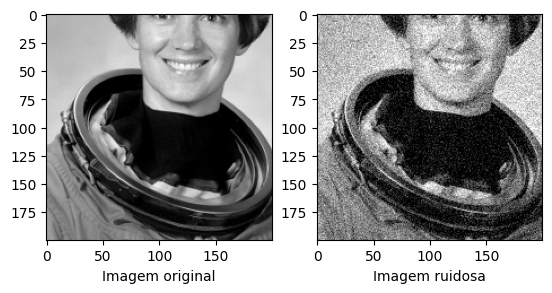

In [6]:
im, im_name = get_image(image)
im, im_nse, sigma_est = process_image(im, sig, seed, cut_shapes[image])

plt.set_cmap('gray')
plt.figure()

plt.subplot(1, 2, 1)
plt.xlabel('Imagem original')
plt.imshow(im)

plt.subplot(1, 2, 2)
plt.xlabel('Imagem ruidosa')
plt.imshow(im_nse)
plt.show()

## Non-Local Means SAP
For comparison the Non-Local Means SAP (the algorithm on which UDLF Non-Local Means is based) is run as well. 

CPU times: user 48.8 s, sys: 694 ms, total: 49.5 s
Wall time: 49.7 s


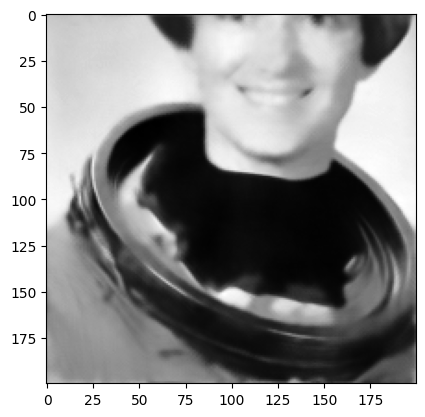

In [7]:
%%time
im_fil1 = nlmeans(im_nse, hW, hP, tau, sigma_est, shape)
plt.imshow(im_fil1)

## UDLF Non-Local Means (NONE)
The results of the reranking method will be compared with Non-Local Means using the original ranked lists, that is, the ranked lists used as input to UDLF. 

CPU times: user 56.4 s, sys: 1.35 s, total: 57.7 s
Wall time: 57.8 s


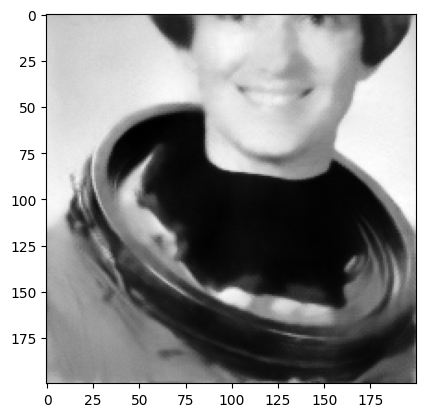

In [8]:
%%time
im_fil3 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, 'NONE', None, n_w)
rm_tmp_files()
plt.imshow(im_fil3, cmap='gray')

## UDLF Non-Local Means (CPRR)
This denoise the image using CPRR as the reranking method.

CPU times: user 58.1 s, sys: 1.61 s, total: 59.7 s
Wall time: 1min 13s


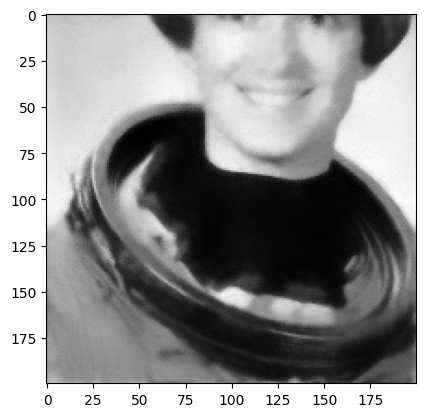

In [9]:
%%time
im_fil2 = nlmeans_udlf(im_nse, hW, hP, tau, sigma_est, shape, udl_method, udl_params, n_w)
rm_tmp_files()
plt.imshow(im_fil2)

### Show the images side by side

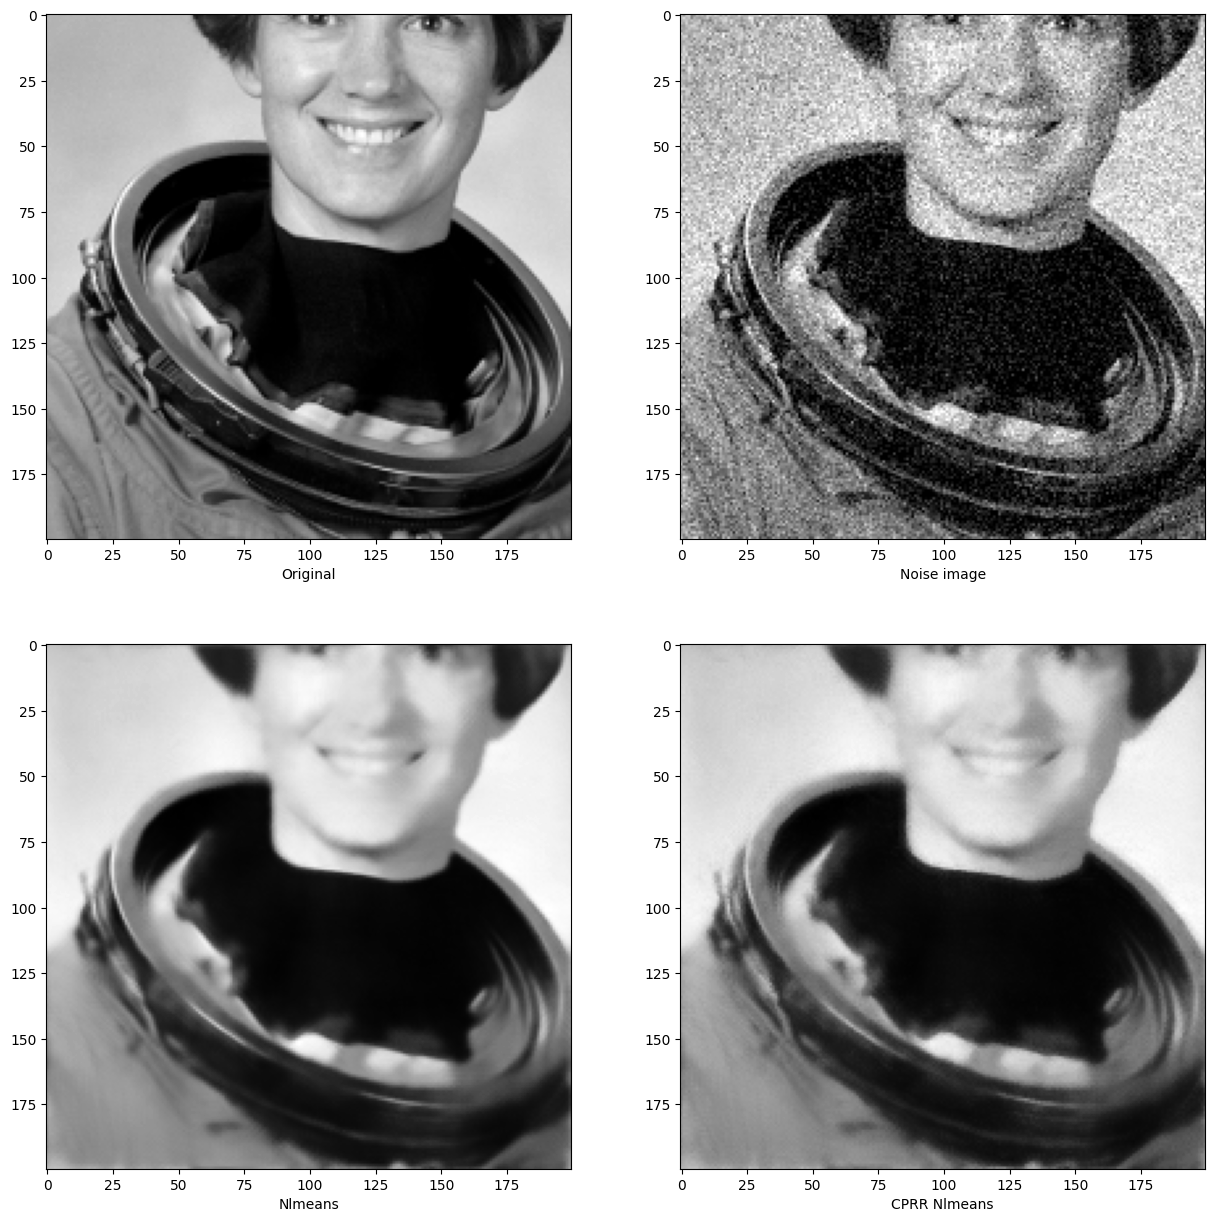

,Noise,Nlmeans,CPRR Nlmeans,NONE Nlmeans
PSNR,20.582626,23.142633,22.926842,23.327438
SSIM,0.450165,0.679699,0.673615,0.687343
MSE,0.008745,0.003362,0.003605,0.003233


In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
plt.subplot(2, 2, 1)
plt.xlabel('Original')
plt.imshow(im)
plt.subplot(2, 2, 2)
plt.xlabel('Noise image')
plt.imshow(im_nse)
plt.subplot(2, 2, 3)
plt.xlabel('Nlmeans')
plt.imshow(im_fil1)
plt.subplot(2, 2, 4)
plt.xlabel(f'{udl_method} Nlmeans')
plt.imshow(im_fil2)
plt.show()

im_noise_psnr, im_noise_ssim, im_noise_mse = image_metrics(im, im_nse)
im_nlm_psnr, im_nlm_ssim, im_nlm_mse = image_metrics(im, im_fil1)
im_udlf_psnr, im_udlf_ssim, im_udlf_mse = image_metrics(im, im_fil2)
im_none_psnr, im_none_ssim, im_none_mse = image_metrics(im, im_fil3)

# Updates the figure size
plt.rcParams['figure.figsize'] = [15, 5]

pd.DataFrame(
    data   = np.array([[im_noise_psnr, im_nlm_psnr, im_udlf_psnr, im_none_psnr],
                       [im_noise_ssim, im_nlm_ssim, im_udlf_ssim, im_none_ssim],
                       [im_noise_mse,  im_nlm_mse,  im_udlf_mse,  im_none_mse]]),
    index   = ['PSNR', 'SSIM', 'MSE'],
    columns = ['Noise', 'Nlmeans', f'{udl_method} Nlmeans', 'NONE Nlmeans'],
)